# Effect of particle displacement & Effect of the particle diameters
- with synthetic PIV images
- Optical Flow in Exp3-1, and Cross Correlation in Exp3-2

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from flow import uniform, solid_rot, lamb_oseen, sin_flow
from pig import config, gen_piv_pair, AttrDict
from metrics import PIVmetric 

from deformpiv import DeformPIV
from fdi2cdi import fdi2cdi

# from raft import raft_estimator

# x, y, u, v = raft_estimator(img1, img2)

np.random.seed(202407)

In [2]:
# Test the performance on the synthetic images
def one_case(img1,img2, Vs,show=True):
    def estimate(img1, img2, deform="CDI", pivmethod="crosscorrelation"):
        config = AttrDict()
        config.pivmethod = pivmethod # ['crosscorrelation', 'opticalflow', 'raft_estimator']
        config.deform = deform # ['FDI', 'CDI', 'CDDI', 'FDDI']
        config.runs = 6
        
        piv = DeformPIV(config)
        # x, y, u, v = piv.compute(img1, img2, np.float32(Vs[0][1]), np.float32(Vs[0][0]))
        img1, img2 = cv2.blur(img1, (3,3)), cv2.blur(img2, (3,3)) 
        x, y, u, v = piv.compute(img1, img2)
        return x,y,v,u
    
    x, y, u_fdi, v_fdi = estimate(img1, img2, deform="FDI")
    x, y, u_cdi, v_cdi = estimate(img1, img2, deform="CDI")
    # x, y, u_raft, v_raft = raft_estimator(img1, img2)

    
    u_fdi2cdi,v_fdi2cdi = fdi2cdi(u_fdi,v_fdi, t=0, delta=1)
    
    if show:
        print("FDI:")
    res1 = PIVmetric(Vs[0][0][10:-10,10:-10],Vs[0][1][10:-10,10:-10],u_fdi[10:-10,10:-10],v_fdi[10:-10,10:-10],show=show)
    # PIVmetric(Vs[1][0][10:-10,10:-10],Vs[1][1][10:-10,10:-10],u_fdi[10:-10,10:-10],v_fdi[10:-10,10:-10])
    if show:
        print("CDI:")
    res2 = PIVmetric(Vs[0][0][10:-10,10:-10],Vs[0][1][10:-10,10:-10],u_cdi[10:-10,10:-10],v_cdi[10:-10,10:-10],show=show)
    # PIVmetric(Vs[2][0][10:-10,10:-10],Vs[2][1][10:-10,10:-10],u_cdi[10:-10,10:-10],v_cdi[10:-10,10:-10])
    if show:
        print("FDI2CDI:")
    res3 = PIVmetric(Vs[0][0][10:-10,10:-10],Vs[0][1][10:-10,10:-10],u_fdi2cdi[10:-10,10:-10],v_fdi2cdi[10:-10,10:-10],show=show)
    # PIVmetric(Vs[0][0][10:-10,10:-10],Vs[0][1][10:-10,10:-10],Vs[2][0][10:-10,10:-10],Vs[2][1][10:-10,10:-10])
    # print("RAFT:")
    # PIVmetric(Vs[0][0][10:-10,10:-10],Vs[0][1][10:-10,10:-10],u_raft[10:-10,10:-10],v_raft[10:-10,10:-10])
    return res1,res2,res3

In [3]:
def clipx(imgs, VS):
    imgs_ = imgs[0][25:-25,25:-25], imgs[1][25:-25,25:-25]
    Vs0_ = (VS[0][0][25:-25,25:-25], VS[0][1][25:-25,25:-25])
    Vs1_ = (VS[1][0][25:-25,25:-25], VS[1][1][25:-25,25:-25])
    Vs2_ = (VS[2][0][25:-25,25:-25], VS[2][1][25:-25,25:-25])
    Vs_ = (Vs0_, Vs1_, Vs2_)
    return imgs_, Vs_

def one_test(dx=0.5, dp=2.5, show=True):
    def flow(x,y):
        return uniform(x, y, uc=dx, vc=0)

    # generate test data
    cfg = config()
    cfg.flow = flow
    cfg.dp = dp
    imgs, Vs = gen_piv_pair(cfg)
    imgs, Vs = clipx(imgs,Vs)
    img1, img2 = imgs[0], imgs[1]
    
    # perform evaluation
    res = one_case(img1, img2, Vs, show=show)
    return res

_ = one_test()

FDI:
0.0173(RMSE)	0.0148(AEE)	0.0161(AAE,rad)	0.6487(SSIM)	0.9955(MoC)	0(Outlier)	
CDI:
0.0540(RMSE)	0.0510(AEE)	0.0283(AAE,rad)	0.5673(SSIM)	0.9032(MoC)	0(Outlier)	
FDI2CDI:
0.0173(RMSE)	0.0147(AEE)	0.0160(AAE,rad)	0.6501(SSIM)	0.9955(MoC)	0(Outlier)	


In [4]:
displacements = np.linspace(0,10,101)
results = []
for dx in tqdm(displacements):
    results.append(one_test(dx=dx, show=False))

print(np.array(results).shape)

  0%|                                                   | 0/101 [00:00<?, ?it/s]/home/aijia/miniconda3/envs/venv/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
100%|█████████████████████████████████████████| 101/101 [20:15<00:00, 12.03s/it]

(101, 3, 6)


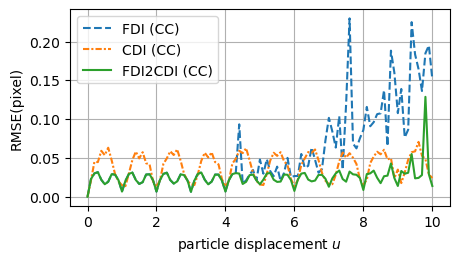

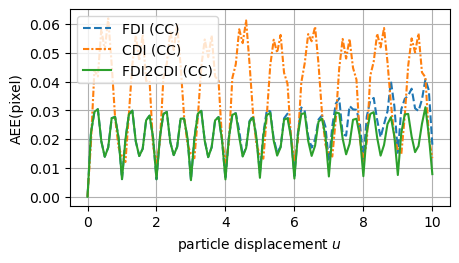

In [8]:
results = np.array(results)
linestyles = ['--', (0, (3, 1, 1, 1)), '-',':', (0, (3, 1, 1, 1, 1, 1)), '-.', ':']

plt.figure(figsize=(4.5,2.5))
plt.plot(displacements, results[:,0,0], linestyle=linestyles[0], label="FDI (CC)")
plt.plot(displacements, results[:,1,0], linestyle=linestyles[1], label="CDI (CC)")
plt.plot(displacements, results[:,2,0], linestyle=linestyles[2], label="FDI2CDI (CC)")
plt.legend(loc=0)
plt.grid("on")
plt.xlim(-0.5,10.5)
plt.tight_layout()
plt.xlabel("particle displacement $u$")
plt.ylabel("RMSE(pixel)")
plt.savefig("output/Fig9_cx.pdf", bbox_inches='tight')

# plt.title("RMSE")

plt.figure(figsize=(4.5,2.5))
plt.plot(displacements, results[:,0,1], linestyle=linestyles[0], label="FDI (CC)")
plt.plot(displacements, results[:,1,1], linestyle=linestyles[1], label="CDI (CC)")
plt.plot(displacements, results[:,2,1], linestyle=linestyles[2], label="FDI2CDI (CC)")
plt.legend(loc='upper left')
plt.grid("on")
plt.xlim(-0.5,10.5)
plt.tight_layout()
plt.xlabel("particle displacement $u$")
plt.ylabel("AEE(pixel)")
plt.savefig("output/Fig9_dx.pdf", bbox_inches='tight')
# plt.title("AEE")
plt.show()

In [6]:
diameters = np.linspace(0.1,5,50)
results2 = []
for dp in tqdm(diameters):
    results2.append(one_test(dx=0.5, dp=dp, show=False))

print(np.array(results).shape)

100%|███████████████████████████████████████████| 50/50 [10:02<00:00, 12.05s/it]

(101, 3, 6)


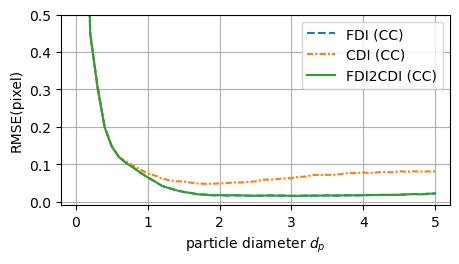

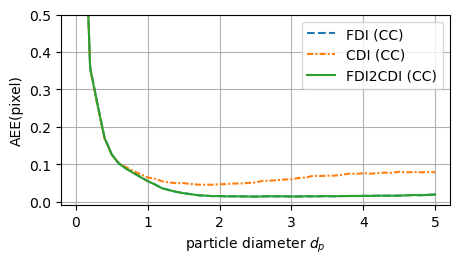

In [7]:
results2 = np.array(results2)
linestyles = ['--', (0, (3, 1, 1, 1)), '-',':', (0, (3, 1, 1, 1, 1, 1)), '-.', ':']

plt.figure(figsize=(4.5,2.5))
plt.plot(diameters, results2[:,0,0], linestyle=linestyles[0], label="FDI (CC)")
plt.plot(diameters, results2[:,1,0], linestyle=linestyles[1], label="CDI (CC)")
plt.plot(diameters, results2[:,2,0], linestyle=linestyles[2], label="FDI2CDI (CC)")
plt.legend(loc=0)
plt.grid("on")
plt.xlim(-0.2,5.2)
plt.ylim(-0.01,0.5)
plt.tight_layout()
# plt.title("RMSE")
plt.xlabel("particle diameter $d_p$")
plt.ylabel("RMSE(pixel)")
plt.savefig("output/Fig10_cx.pdf", bbox_inches='tight')


plt.figure(figsize=(4.5,2.5))
plt.plot(diameters, results2[:,0,1], linestyle=linestyles[0], label="FDI (CC)")
plt.plot(diameters, results2[:,1,1], linestyle=linestyles[1], label="CDI (CC)")
plt.plot(diameters, results2[:,2,1], linestyle=linestyles[2], label="FDI2CDI (CC)")
plt.legend(loc=0)
plt.grid("on")
plt.xlim(-0.2,5.2)
plt.ylim(-0.01,0.5)

plt.tight_layout()
# plt.title("AEE")
plt.xlabel("particle diameter $d_p$")
plt.ylabel("AEE(pixel)")
plt.savefig("output/Fig10_dx.pdf", bbox_inches='tight')

plt.show()